In [10]:
import numpy as np
import pandas as pd
import seaborn as sns
import pickle
import matplotlib.pyplot as plt
import functools

In [11]:
from ema_workbench import ema_logging, MultiprocessingEvaluator, SequentialEvaluator, Samplers

In [12]:
def robustness(direction, threshold, data):
    if direction == SMALLER:
        return np.sum(data<=threshold)/data.shape[0]
    else:
        return np.sum(data>=threshold)/data.shape[0]

SMALLER = 'SMALLER'

def costs(data):
    return data[0]/1e10 # makes numbers nicer

Expected_Number_of_Deaths = functools.partial(robustness, SMALLER, 1) #not ok
Expected_Annual_Damage = functools.partial(robustness, SMALLER, 6e5) #THOSE NUMBERS NEED TO BE SPECIFIED AGAIN
Total_Investment_Costs = costs #THOSE NUMBERS NEED TO BE SPECIFIED AGAIN

In [13]:
from problem_formulation import get_model_for_problem_formulation

model, _ = get_model_for_problem_formulation(1)

In [14]:
ema_logging.log_to_stderr(ema_logging.INFO)

<Logger EMA (DEBUG)>

In [15]:
# enlisting uncertainties, their types (RealParameter/IntegerParameter/CategoricalParameter), lower boundary, and upper boundary
import copy

for unc in model.uncertainties:
    print(repr(unc))

uncertainties = copy.deepcopy(model.uncertainties)

CategoricalParameter('discount rate 0', [0, 1, 2, 3])
CategoricalParameter('discount rate 1', [0, 1, 2, 3])
CategoricalParameter('discount rate 2', [0, 1, 2, 3])
CategoricalParameter('A.1_Brate', [0, 1, 2])
CategoricalParameter('A.2_Brate', [0, 1, 2])
CategoricalParameter('A.3_Brate', [0, 1, 2])
CategoricalParameter('A.4_Brate', [0, 1, 2])
CategoricalParameter('A.5_Brate', [0, 1, 2])


In [16]:
from ema_workbench import (Model, CategoricalParameter,
                           ScalarOutcome, IntegerParameter, RealParameter)

from ema_workbench.em_framework.optimization import EpsilonProgress

In [17]:
from ema_workbench.em_framework import sample_uncertainties
n_scenarios = 10
scenarios = sample_uncertainties(model, n_scenarios)
nfe = int(100)  # Original value: 1000

In [18]:
np.random.seed(0)


In [19]:

MAXIMIZE = ScalarOutcome.MAXIMIZE
MINIMIZE = ScalarOutcome.MINIMIZE

funcs = {'Expected Number of Deaths':Expected_Number_of_Deaths,
         'Expected Annual Damage': Expected_Annual_Damage,
         'Total Investment Costs': Total_Investment_Costs}

robustnes_functions = [ScalarOutcome('Expected Number of Deaths', kind=MAXIMIZE,
                                     function=Expected_Number_of_Deaths),
                       ScalarOutcome('Expected Annual Damage', kind=MAXIMIZE,
                                     function=Expected_Annual_Damage),
                       ScalarOutcome('Total Investment Costs', kind=MAXIMIZE,
                                     function=Total_Investment_Costs),
                      ]
use_pickle4 = False
if use_pickle4:
    with open('data/moro_results6.pickle', 'rb') as filehandler:
        results4 = pickle.load(filehandler)
else:
    # we have to change the plausible max for total investment costs
    convergence = [EpsilonProgress()]

    epsilons=[0.05,]*len(robustnes_functions)  #final value of epsilon should be much lower.Just for experiment purposes is 1
    with MultiprocessingEvaluator(model, n_processes=8) as evaluator:
        results4 = evaluator.robust_optimize(robustnes_functions, scenarios, nfe=nfe,
                                                         convergence=convergence, epsilons=epsilons)
    # Save results in Pickle file
    with open("data/moro_results1.pickle","wb") as filehandler:
        pickle.dump(results4, filehandler)
archive, convergence = results4

100%|████████████████████████████████████████| 100/100 [01:44<00:00,  1.04s/it]
[MainProcess/INFO] optimization completed, found 3 solutions


In [ ]:
archive

,0_RfR 0,0_RfR 1,0_RfR 2,1_RfR 0,1_RfR 1,1_RfR 2,2_RfR 0,2_RfR 1,2_RfR 2,3_RfR 0,...,A.3_DikeIncrease 2,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2,Expected Number of Deaths,Expected Annual Damage,Total Investment Costs
0,0,1,0,1,0,1,0,1,1,1,...,0,2,8,9,3,8,9,1.0,1.0,0.248562


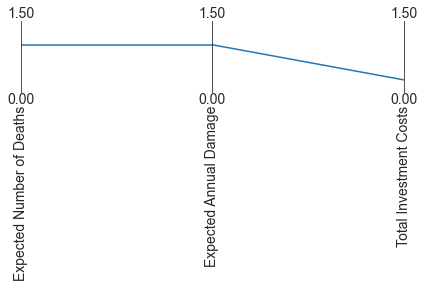

In [ ]:
from ema_workbench.analysis import parcoords

data = archive.loc[:, [o.name for o in robustnes_functions]]
limits = parcoords.get_limits(data)
limits.loc[0, :] = 0
limits.loc[1, :] = 1.5

paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data)
plt.show()

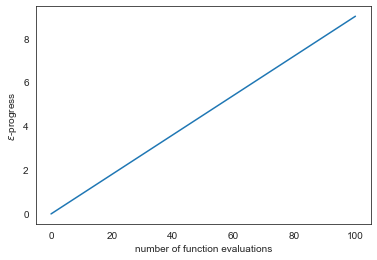

In [ ]:
fig, ax = plt.subplots()
ax.plot(convergence.nfe, convergence.epsilon_progress)
ax.set_ylabel('$\epsilon$-progress')

ax.set_xlabel('number of function evaluations')
plt.show()

In [ ]:
from ema_workbench.analysis import parcoords

experiments, outcomes = results4

funcs = {'Expected Number of Deaths':Expected_Number_of_Deaths,
         'Expected Annual Damage': Expected_Annual_Damage,
         'Total Investment Costs': Total_Investment_Costs}

total_scores = {}
for policy in np.unique(experiments['policy']):
    scores = {}
    logical = experiments['policy'] == policy

    temp_outcomes = {k:v[logical] for k,v in outcomes.items()}

    for k, v in temp_outcomes.items():
        score = funcs[k](v)
        scores[k] = score
    total_scores[policy] = scores

data = pd.DataFrame(total_scores).T.reset_index(drop=True)
limits = parcoords.get_limits(data)

paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data)
plt.show()

KeyError: 'policy'

In [ ]:
results4

(   0_RfR 0  0_RfR 1  0_RfR 2  1_RfR 0  1_RfR 1  1_RfR 2  2_RfR 0  2_RfR 1  \
 0        0        0        0        0        0        0        0        0   
 
    2_RfR 2  3_RfR 0  ...  A.3_DikeIncrease 2  A.4_DikeIncrease 0  \
 0        0        0  ...                   0                   0   
 
    A.4_DikeIncrease 1  A.4_DikeIncrease 2  A.5_DikeIncrease 0  \
 0                   0                   0                   0   
 
    A.5_DikeIncrease 1  A.5_DikeIncrease 2  Expected Number of Deaths  \
 0                   0                   0                        0.0   
 
    Expected Annual Damage  Total Investment Costs  
 0                     0.0                     0.0  
 
 [1 rows x 34 columns],
     epsilon_progress    nfe
 0                  0      0
 1                  6    100
 2                 24   1196
 3                 32   2289
 4                 36   3335
 5                 39   4392
 6                 39   5444
 7                 39   6444
 8                 39   744

In [ ]:
archive.iloc[:, :]

,0_RfR 0,0_RfR 1,0_RfR 2,1_RfR 0,1_RfR 1,1_RfR 2,2_RfR 0,2_RfR 1,2_RfR 2,3_RfR 0,...,A.3_DikeIncrease 2,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2,Expected Number of Deaths,Expected Annual Damage,Total Investment Costs
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.0,0.0,0.0


In [ ]:
with open('data/scenariosselection.pickle', 'rb') as filehandler:
        scenarios = pickle.load(filehandler)

In [ ]:
scenarios

[Scenario({'A.0_ID flood wave shape': 18.0, 'A.1_Bmax': 72.48084744746198, 'A.1_Brate': 1.0, 'A.1_pfail': 0.7379373650211618, 'A.2_Bmax': 113.92586554143531, 'A.2_Brate': 10, 'A.2_pfail': 0.0908087249229613, 'A.3_Bmax': 73.94168010377241, 'A.3_Brate': 1.0, 'A.3_pfail': 0.8495396691401069, 'A.4_Bmax': 285.78579914861456, 'A.4_Brate': 1.0, 'A.4_pfail': 0.1918754575501329, 'A.5_Bmax': 235.06647779187858, 'A.5_Brate': 1.5, 'A.5_pfail': 0.7675186843933242, 'discount rate 0': 4.5, 'discount rate 1': 4.5, 'discount rate 2': 3.5}),
 Scenario({'A.0_ID flood wave shape': 22.0, 'A.1_Bmax': 93.99588525027544, 'A.1_Brate': 1.0, 'A.1_pfail': 0.8778315561026746, 'A.2_Bmax': 328.5607743016249, 'A.2_Brate': 10, 'A.2_pfail': 0.6741971552068695, 'A.3_Bmax': 59.7172688075795, 'A.3_Brate': 10, 'A.3_pfail': 0.9920050540414763, 'A.4_Bmax': 49.012688339540986, 'A.4_Brate': 10, 'A.4_pfail': 0.8318102024423811, 'A.5_Bmax': 59.96563408327613, 'A.5_Brate': 10, 'A.5_pfail': 0.8496313856653827, 'discount rate 0': 4